In [33]:
!pip install palmerpenguins
import pandas as pd
from palmerpenguins import load_penguins
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, roc_auc_score
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split


In [34]:
from palmerpenguins import load_penguins
df = load_penguins()
print(df.head())

  species     island  bill_length_mm  bill_depth_mm  flipper_length_mm  \
0  Adelie  Torgersen            39.1           18.7              181.0   
1  Adelie  Torgersen            39.5           17.4              186.0   
2  Adelie  Torgersen            40.3           18.0              195.0   
3  Adelie  Torgersen             NaN            NaN                NaN   
4  Adelie  Torgersen            36.7           19.3              193.0   

   body_mass_g     sex  year  
0       3750.0    male  2007  
1       3800.0  female  2007  
2       3250.0  female  2007  
3          NaN     NaN  2007  
4       3450.0  female  2007  


In [35]:
#only the two penguins
df = df[df["species"].isin(["Adelie", "Gentoo"])]

#features
features = ["bill_length_mm", "bill_depth_mm", "flipper_length_mm", "body_mass_g"]
df = df[["species"] + features].dropna()


1. Accuracy Comparison:

In [36]:
X = df[features]
y = df["species"]   # keep labels as strings


X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

nb_model = GaussianNB()
lr_model = Pipeline([("lr", LogisticRegression(max_iter=500))])
nb_model.fit(X_train, y_train)
lr_model.fit(X_train, y_train)
nb_train_pred = nb_model.predict(X_train)
nb_test_pred = nb_model.predict(X_test)
lr_train_pred = lr_model.predict(X_train)
lr_test_pred = lr_model.predict(X_test)
nb_train_acc = accuracy_score(y_train, nb_train_pred)
nb_test_acc = accuracy_score(y_test, nb_test_pred)
lr_train_acc = accuracy_score(y_train, lr_train_pred)
lr_test_acc = accuracy_score(y_test, lr_test_pred)
print("Naive Bayes Train Accuracy:", nb_train_acc)
print("Naive Bayes Test Accuracy:", nb_test_acc)
print("Logistic Regression Train Accuracy:", lr_train_acc)
print("Logistic Regression Test Accuracy:", lr_test_acc)

#Both models are 100% accurate

Naive Bayes Train Accuracy: 1.0
Naive Bayes Test Accuracy: 1.0
Logistic Regression Train Accuracy: 1.0
Logistic Regression Test Accuracy: 1.0


AUC (Area Under the ROC Curve) Comparison:

In [37]:
nb_train_probs = nb_model.predict_proba(X_train)[:, 1]
nb_test_probs = nb_model.predict_proba(X_test)[:, 1]
lr_train_probs = lr_model.predict_proba(X_train)[:, 1]
lr_test_probs = lr_model.predict_proba(X_test)[:, 1]
y_train_bin = (y_train == "Gentoo").astype(int)
y_test_bin = (y_test == "Gentoo").astype(int)
nb_train_auc = roc_auc_score(y_train_bin, nb_train_probs)
nb_test_auc = roc_auc_score(y_test_bin, nb_test_probs)
lr_train_auc = roc_auc_score(y_train_bin, lr_train_probs)
lr_test_auc = roc_auc_score(y_test_bin, lr_test_probs)
print("\n--- AUC Scores ---")
print("Naive Bayes Train AUC:", nb_train_auc)
print("Naive Bayes Test AUC:", nb_test_auc)
print("Logistic Regression Train AUC:", lr_train_auc)
print("Logistic Regression Test AUC:", lr_test_auc)

#Both models are just as affective


--- AUC Scores ---
Naive Bayes Train AUC: 1.0
Naive Bayes Test AUC: 1.0
Logistic Regression Train AUC: 1.0
Logistic Regression Test AUC: 1.0


3. Lift and Gain Charts:

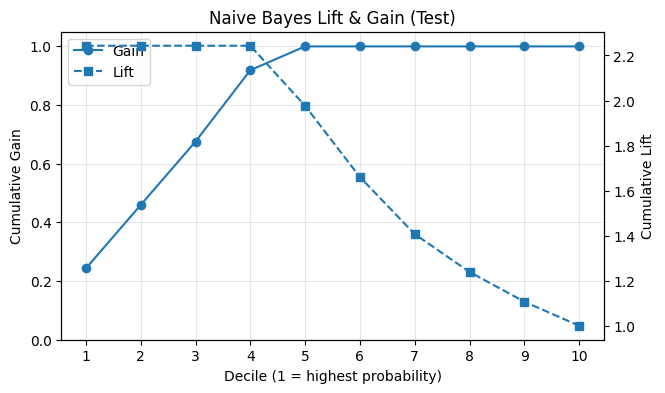

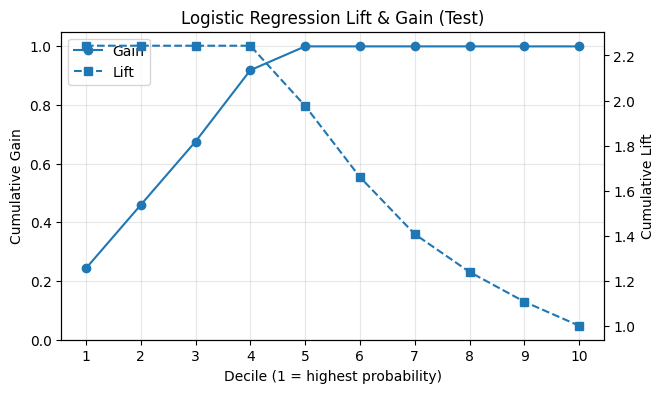

In [40]:

pos_class = "Gentoo"
nb_probs = nb_model.predict_proba(X_test)[:, list(nb_model.classes_).index(pos_class)]
lr_probs = lr_model.predict_proba(X_test)[:, list(lr_model.classes_).index(pos_class)]
def lift_gain(y_true, probs):
    df = pd.DataFrame({"actual": y_true,"prob": probs})
    df = df.sort_values("prob", ascending=False).reset_index(drop=True)
    df["is_gentoo"] = df["actual"] == pos_class
    df["decile"] = (df.index * 10 // len(df)) + 1
    results = []
    total_gentoo = df["is_gentoo"].sum()
    base_rate = total_gentoo / len(df)
    cum_gentoo = 0
    cum_total = 0
    for d in range(1, 11):
        temp = df[df["decile"] == d]
        gentoo_count = temp["is_gentoo"].sum()
        total_count = len(temp)
        cum_gentoo += gentoo_count
        cum_total += total_count
        gain = cum_gentoo / total_gentoo
        lift = (cum_gentoo / cum_total) / base_rate
        results.append([d, gain, lift])
    return pd.DataFrame(results, columns=["Decile", "Gain", "Lift"])
nb_table = lift_gain(y_test, nb_probs)
lr_table = lift_gain(y_test, lr_probs)
def plot_lift_gain(table, title):
    fig, ax1 = plt.subplots(figsize=(7,4))
    ax2 = ax1.twinx()
    ax1.plot(table["Decile"], table["Gain"], marker="o", label="Gain")
    ax2.plot(table["Decile"], table["Lift"], marker="s", linestyle="--", label="Lift")
    ax1.set_xlabel("Decile (1 = highest probability)")
    ax1.set_ylabel("Cumulative Gain")
    ax2.set_ylabel("Cumulative Lift")
    ax1.set_xticks(range(1,11))
    ax1.set_ylim(0,1.05)
    ax1.set_title(title)
    ax1.grid(True, alpha=0.3)
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines1 + lines2, labels1 + labels2)
    plt.show()
plot_lift_gain(nb_table, "Naive Bayes Lift & Gain (Test)")
plot_lift_gain(lr_table, "Logistic Regression Lift & Gain (Test)")

#Both models are just as good


Model Performance Comparison:

On the basis of these results, it can be determined that both Naive Bayes and Logistic Regression have performed perfectly in classifying Adelie and Gentoo penguins, as they have shown almost identical Lift Chart and Gain Chart results, indicating that one model is not better than the other in classifying these bird species, as they are easily separable on the basis of selected physical features.

In [43]:
X, y = fetch_openml("mnist_784", version=1, as_frame=False, return_X_y=True)
y = y.astype(int)
X = (X.astype(np.float32) / 255.0)

N = 5000
X_sub, _, y_sub, _ = train_test_split(
    X, y, train_size=N, random_state=42, stratify=y
)

X_train, X_test, y_train, y_test = train_test_split(
    X_sub, y_sub, test_size=0.25, random_state=42, stratify=y_sub
)

nb = GaussianNB()
lr = Pipeline([
    ("scaler", StandardScaler(with_mean=False)),
    ("lr", LogisticRegression(
        max_iter=150,
        solver="saga",
        multi_class="multinomial",
        n_jobs=-1
    ))
])

nb.fit(X_train, y_train)
lr.fit(X_train, y_train)
print("Naive Bayes Train:", accuracy_score(y_train, nb.predict(X_train)))
print("Naive Bayes Test: ", accuracy_score(y_test, nb.predict(X_test)))
print("LogReg Train:     ", accuracy_score(y_train, lr.predict(X_train)))
print("LogReg Test:      ", accuracy_score(y_test, lr.predict(X_test)))
nb_proba = nb.predict_proba(X_test)
lr_proba = lr.predict_proba(X_test)

print("Naive Bayes Test AUC:", roc_auc_score(y_test, nb_proba, multi_class="ovr", average="macro"))
print("LogReg Test AUC:     ", roc_auc_score(y_test, lr_proba, multi_class="ovr", average="macro"))

"""
The Logistic Regression model performs much better on the MNIST image dataset compared to the Naive Bayes model because
it is capable of learning complex patterns from pixel information. The Naive Bayes model does not perform well on this
dataset because it is unable to take into account the dependency between pixels, which is not true since it is an image
dataset. On the penguin dataset, which is a simpler dataset, both the models performed equally well as it was relatively
easy to distinguish between two species.
"""


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Naive Bayes Train: 0.5845333333333333
Naive Bayes Test:  0.5952
LogReg Train:      0.9656
LogReg Test:       0.9064
Naive Bayes Test AUC: 0.9075928948248719
LogReg Test AUC:      0.9899716142200591
